# Código de estudio de relación de datos de oleaje y viento



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
from mikeio import Dfs0
from mikeio import Dfs2
import pandas as pd
import funciones as fn
import seaborn as sns

def plot_spectra2D(data, time):
    '''
    Data: mikeio.DataSet 
            hint: Dfs2("text").read()
    time: int
    '''
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # Make data.
    X = np.arange(0, data.shape[2], 1)
    Y = np.arange(0, data.shape[2], 1)
    X, Y = np.meshgrid(X, Y)
    Z = data.isel([time],axis=0)[0][0]
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()    
    
def plot_spectra_polar(data, time):

    deltaf= data.i[1]-data.i[0]
    f=[]
    for i in range(len(data.i)):
        if deltaf<1:
            f.append(float(data.i[0] + i*deltaf))
        else:
            f.append(float(data.i[0]*deltaf**i))

    df = pd.DataFrame(columns = data.j, index = [1/freq for freq in f], 
                        data =np.array(data["Wave energy density"][time,:,:]))    

    return fn.plot_spectra(df, item = None, tstep = None, 
                 figsize = (8,8), cmap = 'viridis', cbar = False, cbar_label = None, 
                 levels = 'auto', ax = None, extend = 'both',
                 watermark = None, prdw_logo_path = None, 
                 prdw_logo_size = [0.69, 0.75, 0.15, 0.15], 
                 prdw_logo_alpha = 0.5, fig = None)
    
def plot_waves(dataframe, variable, fecha_inicial, fecha_final):
    '''
    dataframe: dataframe. 
            hint: dataframe = Dfs0("text.dfs0").read().to_dataframe()
    variable: string
    fecha_inicial: string 
    fecha_final: string
    
    Example: plot_waves(df,"Hm0","2000-12-1","2001-12-2")
    '''
    a = dataframe[variable][fecha_inicial:fecha_final]
    
    if str(variable)=="Hm0":
        tit= "Altura ola"; label="metros"
    elif str(variable) == "Tp":
        tit= "Periodo ola"; label="segundos"
    elif str(variable) == "Mean Dir":
        tit= "Dirección ola"; label="grados"
    elif str(variable) == "DSD":  
        tit= "Desviación estándar direccional"; label="grados"
        
    a.plot(xlabel="Tiempo", ylabel=label ,title= f"{tit}, Valparaíso 33S - 72W")
    



def plot_wind(dataserie, variable, time, lat, lon):
    """
    Dataserie: xarray.Dataset
    variable: string
    time: int
    lat = slice
    lon = slice
    """
    return dataserie[variable].isel(time=time).sel(latitude=lat,longitude=lon).plot()



def cut_netcdf(new_file):
    '''
    This function crop the netcdf file in two files and get rid of expver dimension
    return two files without the expver dimension
    '''
    ds2 = xr.open_dataset(new_file)
    times = []
    
    for var in ds2:
        for t in reversed(range(ds2[var].shape[0])):
            if pd.isna(ds2[var].isel(time=t,expver=1))[0,0]:
                print(var," expvar format is 1 until time ",np.array(ds2["time"].isel(time=t)))
                times.append([var,t])
                break
        continue
    print(times)
    
    if times[0][1]==times[1][1]:
        
        rango1 = slice(None, str(np.array(ds2["time"].isel(time=times[0][1]))))
        rango5 = slice(str(np.array(ds2["time"].isel(time=times[0][1]+1))),None)
        
        ds2_era1 = ds2.isel(expver=0).sel(time=rango1).drop('expver',dim=None)
        ds2_era5 = ds2.isel(expver=1).sel(time=rango5).drop('expver',dim=None)
        
        ds2_era1.to_netcdf('cut_netcdf1.nc')
        ds2_era5.to_netcdf('cut_netcdf2.nc')
        
    else:
        return "Time changes of coordinate expvar are diferent for every single variable. further code must be written"+times

    
    
def get_max(data, variable, path=None):
    '''
    data: xarray.Dataset
    variable: string
    path: string, where you want save the file. 
    
    '''
    Emax=[]
    for t in range(dswave.Timestep.shape[0]):
        Emax.append(round(np.max(np.array(dswave[variable][t,:,:])),3))

    dfE = pd.DataFrame(columns = np.array(["Max " + variable]), index = np.array(dswave.Timestep), data =np.array(Emax))
    
    if path != None:
        dfE.to_csv(path+"Max " + variable+ ".csv")
        
    return dfE

def get_mean(data, variable, path=None):
    '''
    data: xarray.Dataset
    variable: string
    path: string, where you want save the file. 
    
    '''
    Emax=[]
    for t in range(dswave.Timestep.shape[0]):
        Emax.append(round(np.mean(np.array(dswave[variable][t,:,:])),3))

    dfE = pd.DataFrame(columns = np.array(["Mean " + variable]), index = np.array(dswave.Timestep), data =np.array(Emax))
    
    if path != None:
        dfE.to_csv(path+"Mean " + variable+".csv")
        
    return dfE

#### The data:
##### Wind:
- Specify the path location on "path1" file as string.
- On names list, fill with the names documents.
- if new data is added, you could use "cut:netcdf" function to solve the era5 problem.

##### Waves:
- Specify the path location on "path2" file as string.

In [7]:
#Wind

names2 = ['Wind_data_part_3.1.nc','Wind_data_part_3.2.nc']
names = ['Wind_data_part0.nc',
         'Wind_data_part1.nc',
         'Wind_data_part2.nc',
         'Wind_data_part3.nc',
         'Wind_data_part4.nc']

path1 = "E:/Data/"              #set location of the files
files = [path1 + name for name in names]
dswind= xr.open_mfdataset(files)



In [3]:
#Waves
path2 = "E:/Data/"
dfs0 = Dfs0(path2 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912_check.dfs0")
#dfs2 = Dfs2(path2 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.dfs2")
dswave= xr.open_dataset(path2 + "NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.nc")

ds0  = dfs0.read()
df0  = dfs0.read().to_dataframe()
#ds2  = dfs2.read()


#dsE= get_max(dswave, "Wave energy density", path=None)

## Wind Dataset

In [5]:
dswind



<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 81, time: 122912)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.5 -109.0 ... -71.0 -70.5 -70.0
  * latitude   (latitude) float32 -10.0 -10.5 -11.0 -11.5 ... -69.0 -69.5 -70.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-01-23T21:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(37984, 121, 81), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(37984, 121, 81), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(37984, 121, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-01-27 23:43:31 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Wave Dataset


In [6]:
dswave

<xarray.Dataset>
Dimensions:              (Timestep: 90584, i: 36, j: 36)
Coordinates:
  * Timestep             (Timestep) datetime64[ns] 1979-01-01T03:00:00 ... 20...
  * i                    (i) float64 0.035 1.135 2.235 ... 36.34 37.44 38.54
  * j                    (j) float64 5.0 15.0 25.0 35.0 ... 335.0 345.0 355.0
    latitude             (i, j) float64 ...
    longitude            (i, j) float64 ...
    easting              (i, j) float64 ...
    northing             (i, j) float64 ...
Data variables:
    Wave energy density  (Timestep, i, j) float64 ...
Attributes:
    AxisUnit:    meter
    Projection:  Latitude:0.0_Longitude:0.0_Orientation:0.0_WkTString:NON-UTM

In [23]:
    
dfEM = pd.DataFrame(columns = np.array(["Max wave energy density", "Mean wave energy density",'u10','v10',name]), index = np.array(dswave.Timestep[memory1:]), data =np.array(NewData))
dfEM.to_csv(path1+"Emax, Emean,u10,v10, msl.csv") 


In [26]:
for var2 in dfEM.columns:
    var1 = "Max wave energy density"
    print("Correlation "+ str(var1)+" / " + str(var2), float(dfEM[var1].corr(dfEM[var2])))
for var2 in dfEM.columns:
    var1 = "Mean wave energy density"
    print("Correlation "+ str(var1)+" / " + str(var2), float(dfEM[var1].corr(dfEM[var2])))

Correlation Max wave energy density / Max wave energy density 1.0
Correlation Max wave energy density / Mean wave energy density 0.9005817163590396
Correlation Max wave energy density / u10 0.17025747952276424
Correlation Max wave energy density / v10 0.05254296324358087
Correlation Max wave energy density / Mean msl of duration: 15 h with lag: 0 h 0.020273735651024156
Correlation Mean wave energy density / Max wave energy density 0.9005817163590396
Correlation Mean wave energy density / Mean wave energy density 1.0
Correlation Mean wave energy density / u10 0.17585843398238524
Correlation Mean wave energy density / v10 0.10067207634134721
Correlation Mean wave energy density / Mean msl of duration: 15 h with lag: 0 h 0.042221373254957104


In [7]:
x.shape

NameError: name 'x' is not defined

In [8]:
Valpo = dswind.sel(time=slice('1979-01-01 03:00:00',  '2010-01-01 00:00:00'),longitude=slice(-110,-70),latitude=slice(-10,-70))


In [5]:

from keras.models import Sequential 
from keras.layers import AveragePooling2D

In [9]:
u10=np.array(Valpo.u10)
u10=u10.reshape(90584, 121, 81,1)

In [10]:
v10=np.array(Valpo.v10)
v10=v10.reshape(90584, 121, 81,1)

In [11]:
msl=np.array(Valpo.msl)
msl=msl.reshape(90584, 121, 81,1)

In [12]:
Wind=u10 
#define a Average pooling layer
Average_pool = AveragePooling2D(pool_size = 10, strides = 4)
 
#define a sequential model with just one pooling layer
model = Sequential( 
    [Average_pool]) 
   
#get the output 
output = model.predict(Wind) 
   
#print the output  
output = np.squeeze(output) 
print(output.shape) 
u10=output

(90584, 28, 18)


In [13]:
Wind=v10 
#define a Average pooling layer
Average_pool = AveragePooling2D(pool_size = 10, strides = 4)
 
#define a sequential model with just one pooling layer
model = Sequential( 
    [Average_pool]) 
   
#get the output 
output = model.predict(Wind) 
   
#print the output  
output = np.squeeze(output) 
print(output.shape) 
v10=output

(90584, 28, 18)


In [14]:
Wind=msl 
#define a Average pooling layer
Average_pool = AveragePooling2D(pool_size = 10, strides = 4)
 
#define a sequential model with just one pooling layer
model = Sequential( 
    [Average_pool]) 
   
#get the output 
output = model.predict(Wind) 
   
#print the output  
output = np.squeeze(output) 
print(output.shape) 
msl=output


(90584, 28, 18)


In [15]:
msl =msl.reshape(90584, 28, 18,1)
v10 =v10.reshape(90584, 28, 18,1)
u10 =u10.reshape(90584, 28, 18,1)

In [16]:
Wind = np.append(u10,(np.append(v10,msl,axis=3)),axis=3)

In [17]:
x = np.linspace(-110,-70,num=18)
y = np.linspace(-10,-70,num=28)
X, Y = np.meshgrid(x,y)

<ipython-input-18-4b6157bab75f>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X,Y,Wind[1,:,:,0],cmap='RdBu')
<ipython-input-18-4b6157bab75f>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X,Y,Wind[1,:,:,1],cmap='RdBu')
<ipython-input-18-4b6157bab75f>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or

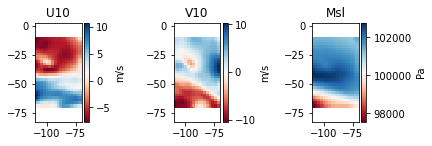

In [18]:
fig=plt.figure()


fig.add_subplot(2,5,1)
plt.axis('equal')
plt.title("U10")
plt.xlabel ='Longitud'
plt.ylabel= 'Latitud'
plt.pcolor(X,Y,Wind[1,:,:,0],cmap='RdBu')
plt.colorbar(label='m/s')

fig.add_subplot(2,5,3)
plt.axis('equal')
plt.title("V10")
plt.xlabel ='Longitud'
plt.ylabel= 'Latitud'
plt.pcolor(X,Y,Wind[1,:,:,1],cmap='RdBu')
plt.colorbar(label='m/s')

fig.add_subplot(2,5,5)
plt.axis('equal')

plt.title("Msl")
plt.xlabel ='Longitud'
plt.ylabel= 'Latitud'
plt.pcolor(X,Y,Wind[1,:,:,2],cmap='RdBu')

plt.colorbar(label='Pa')


In [21]:
Wind.shape[0]

90584

In [22]:

time=48
CorrMax = np.zeros([time,3,4])
CoordMax = np.zeros([Wind.shape[1],Wind.shape[2],3,4])

for lag in range(0,time):
    Corr1 = np.zeros([Wind.shape[1],Wind.shape[2],3,4])
    j = 0
    for var1 in df0:
        for var2 in range(3):
            for row in range(Wind.shape[1]):
                for col in range(Wind.shape[2]):
                    Corr1[row,col,var2,j]= np.corrcoef(df0[var1][lag:],Wind[:int(df0.shape[0] - lag),row,col,var2])[0,1] 
                    if np.abs(Corr1[row,col,var2,j])>CorrMax[lag,var2,j]:
                        CorrMax[lag,var2,j]=np.abs(Corr1[row,col,var2,j])
                        CoordMax[row,col,var2,j]= 1
                       
                        
                    
            #CorrMax[lag,var2,j] =  np.max(np.abs(Corr1[:,:,var2,j]))
        j+=1



In [23]:
wind = ['u10','v10','msl']
wave = ['Hm0','Tp','Mean Dir','DSD']
Wind.shape[1]

28

<ipython-input-27-307c6dce4b86>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[i, j].pcolor(X,Y,Corr1[:,:,i,j],cmap='RdBu',vmin=-0.6,vmax=0.6)
<ipython-input-27-307c6dce4b86>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  fig.colorbar(axs[0, 0].pcolor(X,Y,Corr1[:,:,i,j],cmap='RdBu',vmin=-0.6,vmax=0.6), ax=axs[:, :], location='right', shrink=0.6)


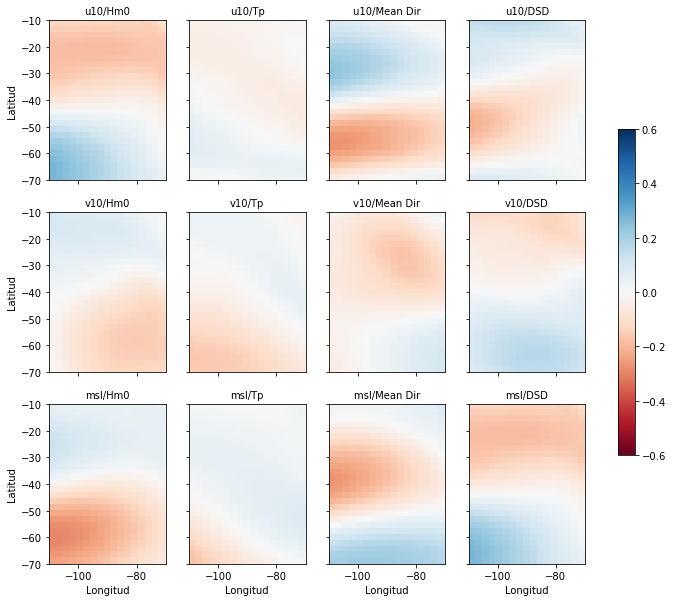

In [27]:
fig, axs = plt.subplots(3, 4,figsize=(12,10))


for i in range(3):
    for j in range(4):
        axs[i, j]
        axs[i, j].pcolor(X,Y,Corr1[:,:,i,j],cmap='RdBu',vmin=-0.6,vmax=0.6)
        axs[i, j].set_title(wind[i]+'/'+wave[j],fontsize=10)
        

for ax in axs.flat:
    ax.set(xlabel='Longitud', ylabel='Latitud')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.colorbar(axs[0, 0].pcolor(X,Y,Corr1[:,:,i,j],cmap='RdBu',vmin=-0.6,vmax=0.6), ax=axs[:, :], location='right', shrink=0.6)
fig.set_facecolor('w')
plt.savefig("correlaciones3.png")


plt.xlabel ='Longitud'
plt.ylabel= 'Latitud'
x = np.linspace(-90,-70,num=18)
y = np.linspace(-20,-50,num=28)
X, Y = np.meshgrid(x,y)

plt.pcolor(X,Y,MHm0,cmap='RdBu')
plt.colorbar(label='Correlación')

In [25]:
Cor=CorrMax

In [62]:
R2=CorrMax**2
R2=np.round(R2,7)
tiempo=np.linspace(0,int(R2.shape[0]*3/24),R2.shape[0])
np.round(R2[:,0,0],7)

array([0.0851403, 0.086406 , 0.095286 , 0.1040635, 0.1129072, 0.124126 ,
       0.1367516, 0.1527199, 0.1678703, 0.1824356, 0.1874246, 0.1911458,
       0.1951367, 0.2025674, 0.2060227, 0.2114437, 0.215334 , 0.217269 ,
       0.2184954, 0.2194723, 0.221693 , 0.2220363, 0.2200752, 0.2184251,
       0.2149359, 0.2108844, 0.204502 , 0.1990843, 0.1922176, 0.1852613,
       0.1780741, 0.1718946, 0.165271 , 0.1581497, 0.1513103, 0.1448877,
       0.1390213, 0.131852 , 0.1242691, 0.1177501, 0.1114352, 0.1047044,
       0.0982709, 0.0924646, 0.0864853, 0.0799681, 0.0736649, 0.0681264])

In [109]:
R2=R2**2

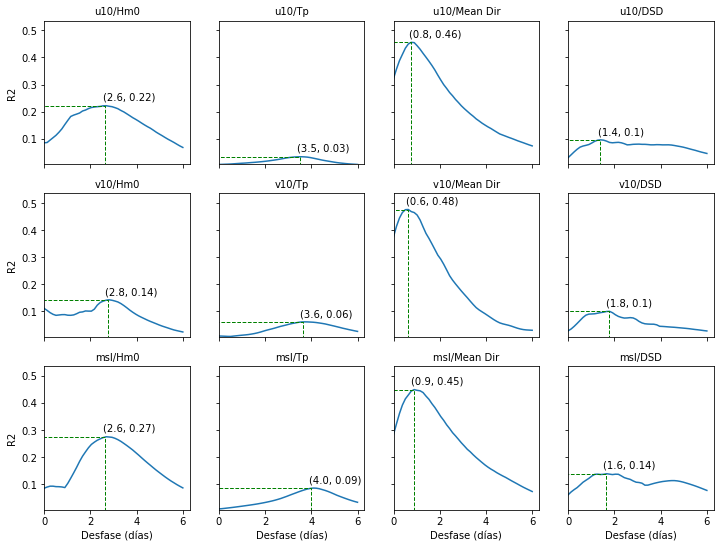

In [110]:
fig, axs = plt.subplots(3, 4,figsize=(12,9))


for i in range(3):
    for j in range(4):
        y=np.max(R2[:,i,j])
        x=int(np.where(R2[:,i,j]==y)[0])*3/24
        axs[i, j].plot(tiempo,R2[:,i,j])
        axs[i, j].plot([x,x,0],[0,y,y],'g',linewidth=1,linestyle='dashed')
        axs[i, j].text(x-0.1,y+0.02,'('+str(round(x,1))+', '+str(round(y,2))+')')
        axs[i, j].set_title(wind[i]+'/'+wave[j],fontsize=10)
        axs[i, j].set_ylim(np.min(R2[:,:,:]),np.max(R2[:,:,:])+0.06)
        axs[i, j].set_xlim(0,6.3)

for ax in axs.flat:
    ax.set(xlabel='Desfase (días)',ylabel='R2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.set_facecolor('w')
plt.savefig("correlaciones.png",dpi=300)

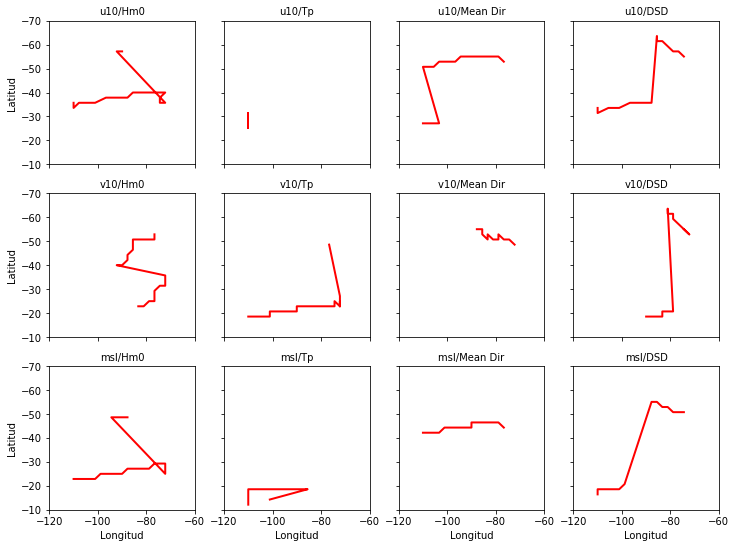

In [122]:
fig, axs = plt.subplots(3, 4,figsize=(12,9))


for i in range(3):
    for j in range(4):
        axs[i, j].plot(CoordMax[:,1,i,j]*40/18 -110,CoordMax[:,0,i,j]*60/28-70,'r',linewidth=2,linestyle='-')
        axs[i, j].set_title(wind[i]+'/'+wave[j],fontsize=10)
        axs[i, j].set_xlim(-120,-60)
        axs[i, j].set_ylim(-10,-70)

for ax in axs.flat:
    ax.set(ylabel='Latitud', xlabel='Longitud')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.set_facecolor('w')
plt.savefig("correlacionescoor2.png",dpi=300)

In [130]:
CoordMax[:,1,2,1]*60/28 -70

array([-61.42857143, -46.42857143, -46.42857143, -46.42857143,
       -46.42857143, -48.57142857, -48.57142857, -48.57142857,
       -50.71428571, -50.71428571, -50.71428571, -52.85714286,
       -52.85714286, -52.85714286, -52.85714286, -52.85714286,
       -55.        , -55.        , -55.        , -57.14285714,
       -57.14285714, -57.14285714, -59.28571429, -59.28571429,
       -61.42857143, -63.57142857, -65.71428571, -65.71428571,
       -67.85714286, -70.        , -70.        , -70.        ,
       -70.        , -70.        , -70.        , -70.        ,
       -70.        , -70.        , -70.        , -70.        ,
       -70.        , -70.        , -70.        , -70.        ,
       -70.        , -70.        , -70.        , -70.        ])

In [33]:
def plotcorr(lat, lon, wave, wind, lag):
    
    wind= wind[:int(df0.shape[0] - lag),lat,lon,2:]
    wave= wave[lag:]
    
    
    
    Data = np.append(wind,np.array(wave), axis = 1)
    Col =np.array(['msl','Hm0','Tp','Mean Dir','DSD'])
    dfnew = pd.DataFrame(columns = Col, index = wave.index, data =Data)
    return sns.pairplot(dfnew)

In [31]:
df0[lag:].shape

(90561, 4)

In [153]:
n =np.array([-1,2])
np.max(np.abs(n))

2

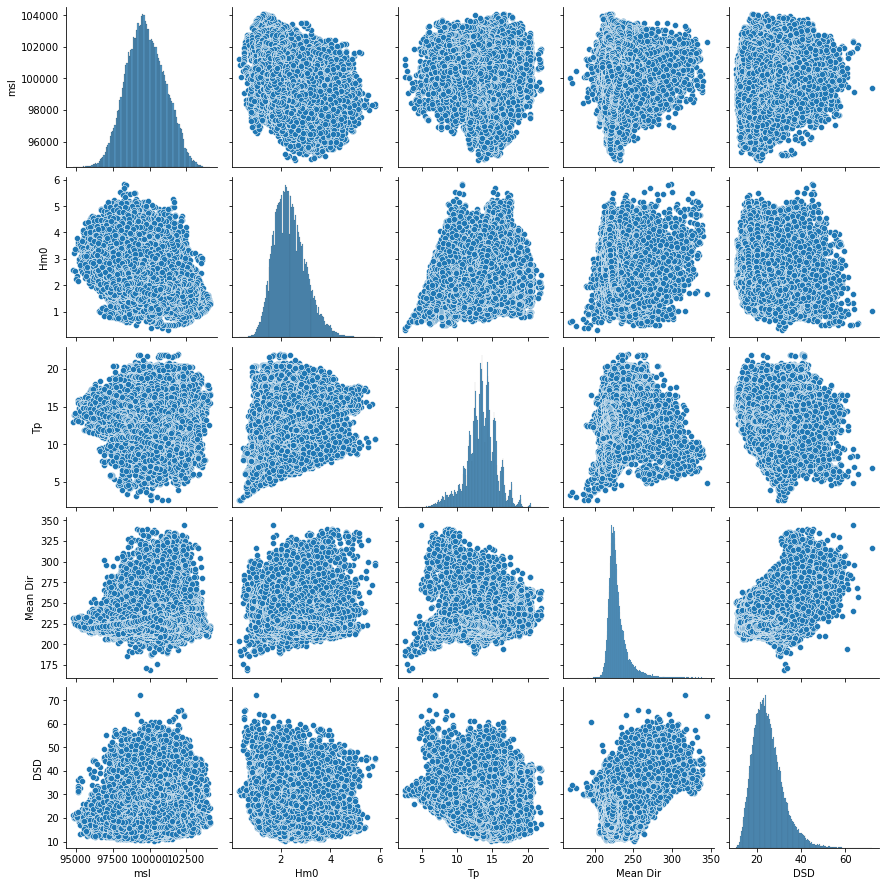

In [35]:

plotcorr(22,15,df0,Wind,20)

In [133]:
time=40

lag=time
Corr4 = np.zeros([Wind.shape[1],Wind.shape[2],3,4])
j = 0
var2 =2
for var1 in df0:
    for row in range(Wind.shape[1]):
        for col in range(Wind.shape[2]):
            Corr4[row,col,var2,j]= np.corrcoef(df0[var1][lag:],Wind[:int(df0.shape[0] - lag),row,col,var2])[0,1] 
    j+=1